In [3]:
"""
NYC Motor Vehicle Collision Analysis
Author: Akhila Korlapati
Description:
This notebook performs ETL, exploratory data analysis, geospatial analysis,
and pattern detection on the NYC Motor Vehicle Collisions dataset using
Python, Pandas, GeoPandas, Folium, and Plotly.
"""

# Import Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

# Geospatial & Mapping Tools
import geopandas as gpd
import folium

# Interactive Visualizations
import plotly.express as px

# Progress Tracking
from tqdm import tqdm

# Optional Machine Learning Models
# (Used for anomaly detection, severity prediction, or time-series)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from prophet import Prophet

# Display Settings
pd.set_option("display.max_columns", None)

In [4]:
# Download NYC Motor Vehicle Collisions Dataset (Full Archive)
# Source: NYC Open Data (Motor Vehicle Collisions - Crashes)
# Dataset ID: h9gi-nx95
# File Size: ~470 MB compressed

DOWNLOAD_URL = (
    "https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD"
)
OUTPUT_PATH = "NYC_Traffic_Accidents_Full.csv"

print("Starting NYC Motor Vehicle Collisions dataset download...")

try:
    # Stream the response in chunks (prevents loading into memory)
    response = requests.get(DOWNLOAD_URL, stream=True)
    response.raise_for_status()  # Validate successful response

    total_size = int(response.headers.get("content-length", 0))
    chunk_size = 1024  # 1KB

    # Save file with progress bar
    with open(OUTPUT_PATH, "wb") as file, tqdm(
        total=total_size,
        unit="iB",
        unit_scale=True,
        desc="Downloading dataset",
    ) as progress_bar:
        for chunk in response.iter_content(chunk_size):
            progress_bar.update(len(chunk))
            file.write(chunk)

    print(f"Download complete. File saved as: {OUTPUT_PATH}")

except Exception as e:
    print("Error downloading dataset:", e)

Starting NYC Motor Vehicle Collisions dataset download...


Download complete. File saved as: NYC_Traffic_Accidents_Full.csv


In [5]:
# Load Full NYC Collision Dataset into Pandas

# Read the full dataset (CSV ~470MB)
# low_memory=False ensures that Pandas does not guess column types in chunks
df = pd.read_csv("NYC_Traffic_Accidents_Full.csv", low_memory=False)

# Display basic dataset dimensions
print(f"Dataset successfully loaded.")
print(f"Total Rows: {df.shape[0]:,}")
print(f"Total Columns: {df.shape[1]:,}\n")

# Show the first few records to confirm structure
display(df.head())

# Print the full list of columns for reference
print("Columns in dataset:")
print(df.columns.tolist())


Dataset successfully loaded.
Total Rows: 2,223,742
Total Columns: 29



,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,2.0,0.0,0,0,0,0,2,0,Aggressive Driving/Road Rage,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,1.0,0.0,0,0,0,0,1,0,Pavement Slippery,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,11/01/2023,1:29,BROOKLYN,11230,40.62179,-73.970024,"(40.62179, -73.970024)",OCEAN PARKWAY,AVENUE K,NaN,1.0,0.0,0,0,0,0,1,0,Unspecified,Unspecified,Unspecified,NaN,NaN,4675373,Moped,Sedan,Sedan,NaN,NaN
3,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Following Too Closely,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
4,09/21/2022,13:21,NaN,NaN,NaN,NaN,NaN,BROOKLYN BRIDGE,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Passing Too Closely,Unspecified,NaN,NaN,NaN,4566131,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN


Columns in dataset:
['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5', 'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5']


In [6]:
# Standardize Column Names

# Many public datasets contain inconsistent formatting in column
# names. Standardizing them ensures reliable downstream analysis
# and prevents errors during merging, querying, or filtering.

df.columns = (
    df.columns
    .str.strip()                   # Remove leading/trailing whitespace
    .str.upper()                   # Convert to uppercase for consistency
    .str.replace(' ', '_')         # Replace spaces with underscores
    .str.replace('-', '_')         # Replace hyphens with underscores
)

# Display standardized column names
print("Standardized Columns:")
print(df.columns.tolist())


Standardized Columns:
['CRASH_DATE', 'CRASH_TIME', 'BOROUGH', 'ZIP_CODE', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'ON_STREET_NAME', 'CROSS_STREET_NAME', 'OFF_STREET_NAME', 'NUMBER_OF_PERSONS_INJURED', 'NUMBER_OF_PERSONS_KILLED', 'NUMBER_OF_PEDESTRIANS_INJURED', 'NUMBER_OF_PEDESTRIANS_KILLED', 'NUMBER_OF_CYCLIST_INJURED', 'NUMBER_OF_CYCLIST_KILLED', 'NUMBER_OF_MOTORIST_INJURED', 'NUMBER_OF_MOTORIST_KILLED', 'CONTRIBUTING_FACTOR_VEHICLE_1', 'CONTRIBUTING_FACTOR_VEHICLE_2', 'CONTRIBUTING_FACTOR_VEHICLE_3', 'CONTRIBUTING_FACTOR_VEHICLE_4', 'CONTRIBUTING_FACTOR_VEHICLE_5', 'COLLISION_ID', 'VEHICLE_TYPE_CODE_1', 'VEHICLE_TYPE_CODE_2', 'VEHICLE_TYPE_CODE_3', 'VEHICLE_TYPE_CODE_4', 'VEHICLE_TYPE_CODE_5']


In [7]:
# Convert Crash Date Column to Standard Datetime Format

# The NYC dataset contains date values in mixed formats (e.g.,
# 'YYYY-MM-DD' and 'MM/DD/YYYY'). To ensure consistency, we create
# a flexible parsing function that attempts multiple formats and
# returns NaT for unrecognized values.

from datetime import datetime

def parse_flexible_date(date_value):
    """
    Attempt to parse date strings using multiple common formats.
    Returns a datetime object if successful, otherwise returns NaT.
    """
    date_value = str(date_value).strip()
    if not date_value:
        return pd.NaT

    # Try multiple known formats
    for fmt in ("%Y-%m-%d", "%m/%d/%Y"):
        try:
            return datetime.strptime(date_value, fmt)
        except ValueError:
            continue  # Try the next format

    # If no format works, return NaT
    return pd.NaT


# Apply parsing function
df["CRASH_DATE"] = df["CRASH_DATE"].apply(parse_flexible_date)

# Extract year field for time-based analysis
df["YEAR"] = df["CRASH_DATE"].dt.year.astype("Int64")

print("Date parsing complete. Example parsed dates:")
display(df[["CRASH_DATE", "YEAR"]].head())

Date parsing complete. Example parsed dates:


,CRASH_DATE,YEAR
0,2021-09-11,2021
1,2022-03-26,2022
2,2023-11-01,2023
3,2022-06-29,2022
4,2022-09-21,2022


In [8]:
# Extract Hour from CRASH_TIME Field

# CRASH_TIME values come in inconsistent formats (e.g., '7:05',
# '07:05 AM', '23:15', '7', '7 PM'). This function extracts the
# hour portion reliably while handling malformed values safely.

import re

def extract_hour(time_value):
    """
    Extracts the hour component from CRASH_TIME using flexible parsing.

    Accepted formats examples:
    - '7:05'
    - '07:05 AM'
    - '23:15'
    - '7'
    - '7 PM'

    Returns:
        Integer hour (0–23) or NaN for invalid/missing values.
    """
    time_value = str(time_value).strip()

    # Handle missing / blank / NaN-like values
    if not time_value or time_value.lower() in {"nan", "none"}:
        return np.nan

    # Extract the first 1–2 digit group (hour component)
    match = re.match(r"^(\d{1,2})", time_value)
    if match:
        hour = int(match.group(1))

        # Validate hour range
        if 0 <= hour <= 23:
            return hour

    return np.nan


# Apply the function to create HOUR column
df["HOUR"] = df["CRASH_TIME"].apply(extract_hour).astype("Int64")

# Summary stats
print(f"Missing hours: {df['HOUR'].isna().sum():,}")
print(f"Unique hours extracted: {sorted(df['HOUR'].dropna().unique())}")


Missing hours: 0
Unique hours extracted: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23)]


In [9]:
# Annual Collision Counts

# Aggregating total number of reported motor vehicle collisions
# per year. This helps identify long-term trends, potential
# anomalies, and the impact of policy or infrastructure changes.

# Group by YEAR and count number of crashes
yearly = (
    df.groupby("YEAR")
      .size()
      .reset_index(name="COUNT")
      .sort_values("YEAR")
)

print("Annual Collision Counts:")
display(yearly)


Annual Collision Counts:


,YEAR,COUNT
0,2012,100545
1,2013,203742
2,2014,206046
3,2015,217708
4,2016,229831
5,2017,231007
6,2018,231564
7,2019,211486
8,2020,112917
9,2021,110557


# Exploratry Data Analysis

Dataset Shape (rows, columns): (2223742, 31)

Column Data Types:


,0
CRASH_DATE,datetime64[ns]
CRASH_TIME,object
BOROUGH,object
ZIP_CODE,object
LATITUDE,float64
LONGITUDE,float64
LOCATION,object
ON_STREET_NAME,object
CROSS_STREET_NAME,object
OFF_STREET_NAME,object



Date Range in Dataset: 2012-07-01 00:00:00 → 2025-11-25 00:00:00

Basic Statistical Summary (Numeric Columns):


,count,mean,std,min,25%,50%,75%,max
LATITUDE,1983359.0,40.588544,2.345047,0.0,40.66733,40.720307,40.769558,43.344444
LONGITUDE,1983359.0,-73.680895,4.357729,-201.35999,-73.97453,-73.92673,-73.86656,0.0
NUMBER_OF_PERSONS_INJURED,2223724.0,0.328609,0.715127,0.0,0.0,0.0,0.0,43.0
NUMBER_OF_PERSONS_KILLED,2223711.0,0.001584,0.042047,0.0,0.0,0.0,0.0,8.0
NUMBER_OF_PEDESTRIANS_INJURED,2223742.0,0.059711,0.250281,0.0,0.0,0.0,0.0,27.0
NUMBER_OF_PEDESTRIANS_KILLED,2223742.0,0.000785,0.028637,0.0,0.0,0.0,0.0,6.0
NUMBER_OF_CYCLIST_INJURED,2223742.0,0.029235,0.170743,0.0,0.0,0.0,0.0,4.0
NUMBER_OF_CYCLIST_KILLED,2223742.0,0.000126,0.01126,0.0,0.0,0.0,0.0,2.0
NUMBER_OF_MOTORIST_INJURED,2223742.0,0.235,0.676246,0.0,0.0,0.0,0.0,43.0
NUMBER_OF_MOTORIST_KILLED,2223742.0,0.000644,0.027755,0.0,0.0,0.0,0.0,5.0


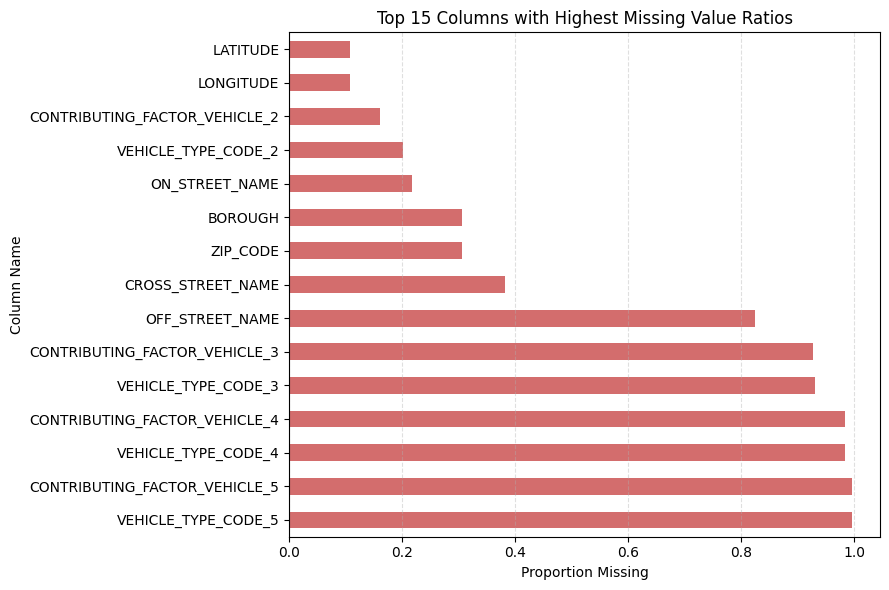


Columns with the Highest Missing Ratios:


,0
VEHICLE_TYPE_CODE_5,0.995615
CONTRIBUTING_FACTOR_VEHICLE_5,0.995473
VEHICLE_TYPE_CODE_4,0.984081
CONTRIBUTING_FACTOR_VEHICLE_4,0.983483
VEHICLE_TYPE_CODE_3,0.930457
CONTRIBUTING_FACTOR_VEHICLE_3,0.927642
OFF_STREET_NAME,0.823572
CROSS_STREET_NAME,0.382154
ZIP_CODE,0.306326
BOROUGH,0.306201


In [10]:
# Basic Dataset Overview & Initial Diagnostics

# This section provides a high-level understanding of the dataset’s
# size, structure, temporal coverage, statistical properties, and
# potential data quality issues such as missing values. These checks
# help determine data reliability before any modeling or trend analysis.

# Dataset Shape
print(f"Dataset Shape (rows, columns): {df.shape}\n")

# Column Summary
print("Column Data Types:")
display(df.dtypes)

# Date Range
min_date, max_date = df["CRASH_DATE"].min(), df["CRASH_DATE"].max()
print(f"\nDate Range in Dataset: {min_date} → {max_date}")

# Basic Statistics for Numeric Columns
numeric_cols = df.select_dtypes(include=["float64", "int64", "Int64"])
print("\nBasic Statistical Summary (Numeric Columns):")
display(numeric_cols.describe().T)

# Missing Values Analysis
# Understanding which columns have high missingness is essential for
# evaluating data quality, identifying potential bias, and determining
# whether imputation, exclusion, or further investigation is necessary.

missing_summary = (
    df.isna()
      .mean()
      .sort_values(ascending=False)
      .head(15)
)

# ---- Plot Missingness ----
plt.figure(figsize=(9, 6))
missing_summary.plot(kind="barh", color="#d36d6d")
plt.title("Top 15 Columns with Highest Missing Value Ratios")
plt.xlabel("Proportion Missing")
plt.ylabel("Column Name")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

print("\nColumns with the Highest Missing Ratios:")
display(missing_summary)


**Temporal Overview**

/tmp/ipython-input-2718467226.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


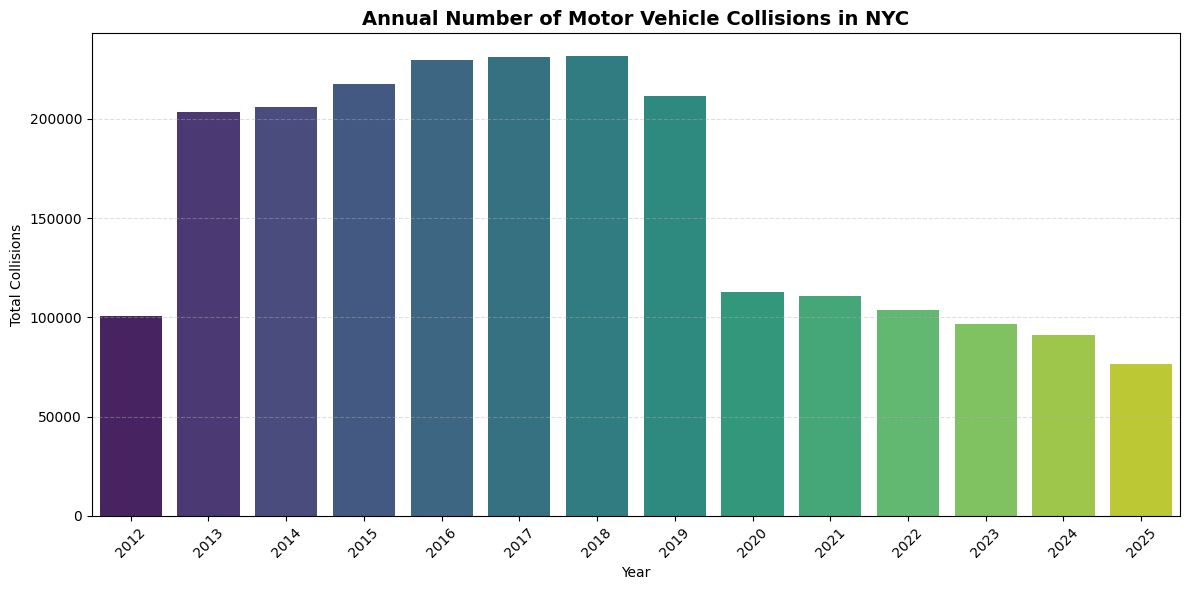

,YEAR,COUNT
0,2012,100545
1,2013,203742
2,2014,206046
3,2015,217708
4,2016,229831
5,2017,231007
6,2018,231564
7,2019,211486
8,2020,112917
9,2021,110557


In [11]:
# Annual Collision Trend Visualization

# Understanding year-over-year changes in total collisions helps
# identify long-term safety trends, potential anomalies, and the
# impact of policy interventions. This visualization provides a
# clear overview of historical patterns in NYC collision counts.

# Aggregate yearly crash counts
yearly = (
    df.groupby("YEAR")
      .size()
      .reset_index(name="COUNT")
      .sort_values("YEAR")
)

# Plot Annual Trend
plt.figure(figsize=(12, 6))
sns.barplot(
    x="YEAR",
    y="COUNT",
    data=yearly,
    palette="viridis"
)

plt.title("Annual Number of Motor Vehicle Collisions in NYC", fontsize=14, fontweight="bold")
plt.xlabel("Year")
plt.ylabel("Total Collisions")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Display table for reference
display(yearly)


/tmp/ipython-input-2784155374.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


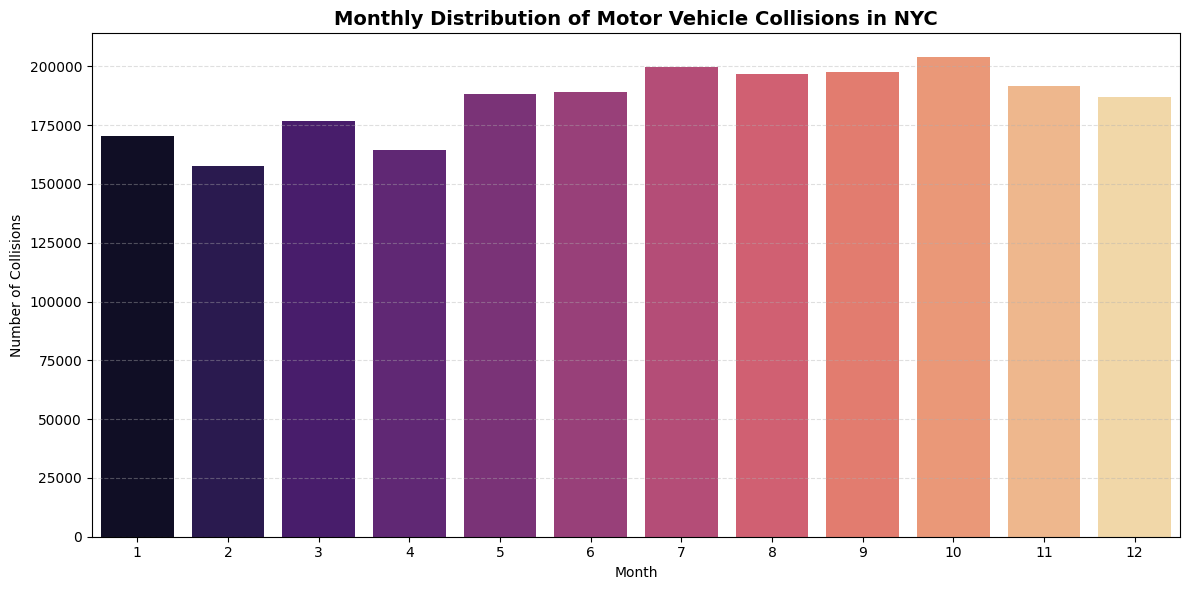

,MONTH,COUNT
0,1,170587
1,2,157501
2,3,176748
3,4,164318
4,5,188409
5,6,189214
6,7,199804
7,8,196934
8,9,197791
9,10,203870


In [12]:
# Monthly Collision Distribution

# Examining monthly crash patterns helps identify seasonal trends,
# weather-related risks, and other cyclical factors that influence
# collision rates. This analysis supports proactive planning for
# public safety and traffic enforcement initiatives.

# Extract month from CRASH_DATE
df["MONTH"] = df["CRASH_DATE"].dt.month

# Aggregate monthly crash counts
monthly = (
    df.groupby("MONTH")
      .size()
      .reset_index(name="COUNT")
      .sort_values("MONTH")
)

# Plot Monthly Distribution
plt.figure(figsize=(12, 6))
sns.barplot(
    x="MONTH",
    y="COUNT",
    data=monthly,
    palette="magma"
)

plt.title("Monthly Distribution of Motor Vehicle Collisions in NYC", fontsize=14, fontweight="bold")
plt.xlabel("Month")
plt.ylabel("Number of Collisions")
plt.xticks(range(0, 12), [f"{m}" for m in range(1, 13)])
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Display table for reference
display(monthly)


/tmp/ipython-input-4097186186.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


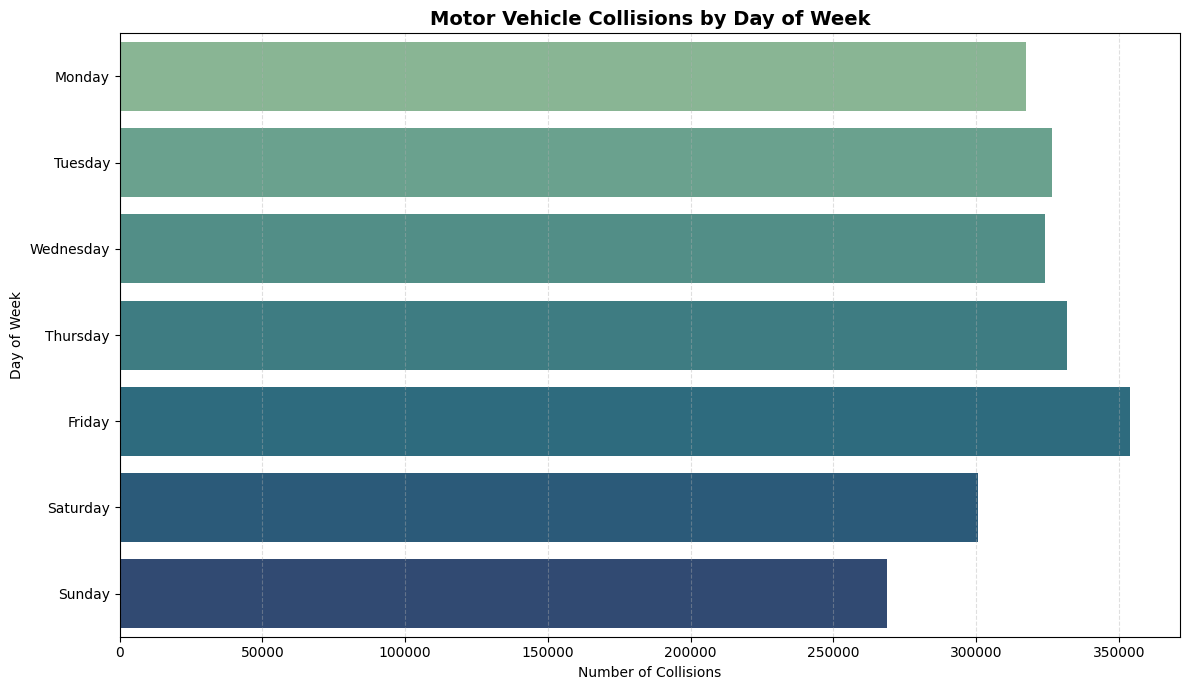

,COUNT
DAY_OF_WEEK,
Monday,317524
Tuesday,326756
Wednesday,324310
Thursday,331958
Friday,353747
Saturday,300530
Sunday,268917


In [13]:
# Collision Distribution by Day of Week

# Analyzing crashes by day of week reveals potential behavioral or
# situational patterns such as weekday commuting risks versus weekend
# leisure-related collisions. These insights support targeted public
# safety interventions and enforcement strategies.

# Extract the day name from CRASH_DATE
df["DAY_OF_WEEK"] = df["CRASH_DATE"].dt.day_name()

# Define a consistent weekday order
weekday_order = [
    "Monday", "Tuesday", "Wednesday", "Thursday",
    "Friday", "Saturday", "Sunday"
]

# Plot Collision Counts by Day
plt.figure(figsize=(12, 7))
sns.countplot(
    y="DAY_OF_WEEK",
    data=df,
    order=weekday_order,
    palette="crest"
)

plt.title("Motor Vehicle Collisions by Day of Week", fontsize=14, fontweight="bold")
plt.xlabel("Number of Collisions")
plt.ylabel("Day of Week")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Generate and display the underlying table
day_of_week_counts = df["DAY_OF_WEEK"].value_counts().reindex(weekday_order)
display(day_of_week_counts.to_frame("COUNT"))


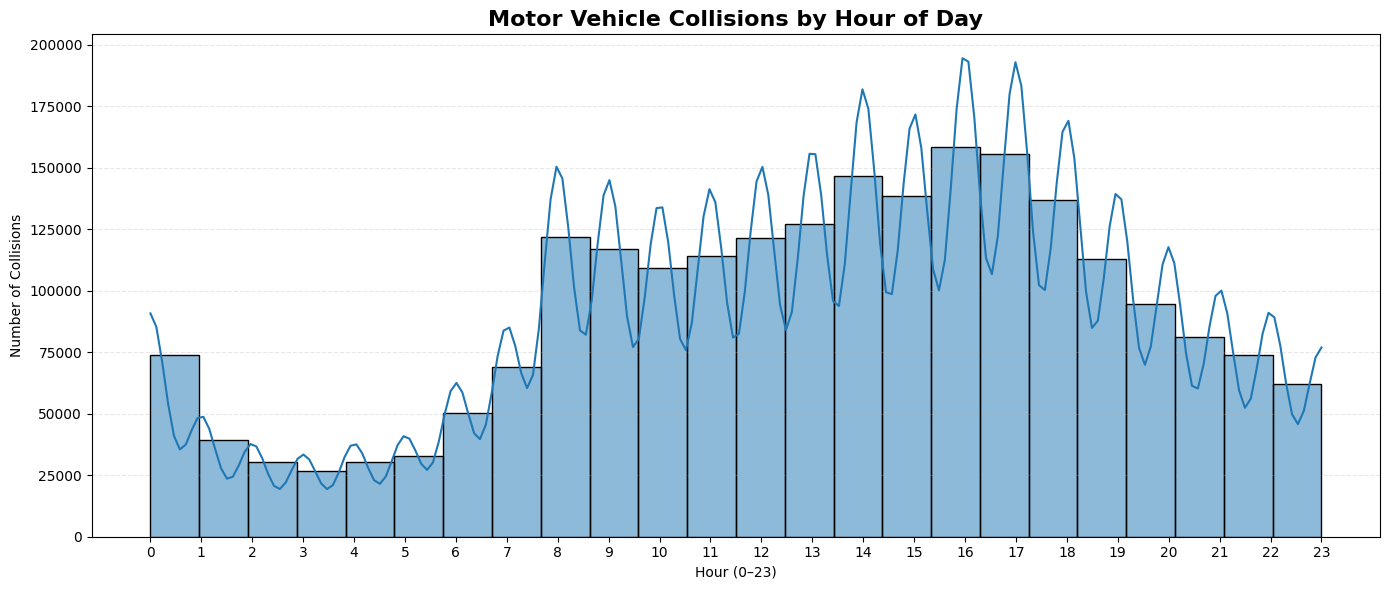

,COUNT
HOUR,
0,73685
1,39461
2,30438
3,26859
4,30482
5,32950
6,50325
7,68793
8,121833


In [14]:
# Collision Distribution by Hour of Day

# Examining collision frequency by hour reveals time-based risk
# patterns such as rush-hour hazards, late-night impaired driving
# risks, and periods of unusually high or low crash volume. These
# insights can guide traffic enforcement, resource allocation, and
# public safety interventions.

# Filter out missing hour values
hour_data = df["HOUR"].dropna()

# Plot Hourly Collision Distribution
plt.figure(figsize=(14, 6))
sns.histplot(
    hour_data,
    bins=24,
    kde=True,
    color="#1f77b4"
)

plt.title("Motor Vehicle Collisions by Hour of Day", fontsize=16, fontweight="bold")
plt.xlabel("Hour (0–23)")
plt.ylabel("Number of Collisions")
plt.xticks(range(0, 24))
plt.grid(axis="y", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

# Display summary counts
hour_counts = hour_data.value_counts().sort_index()
display(hour_counts.to_frame("COUNT"))


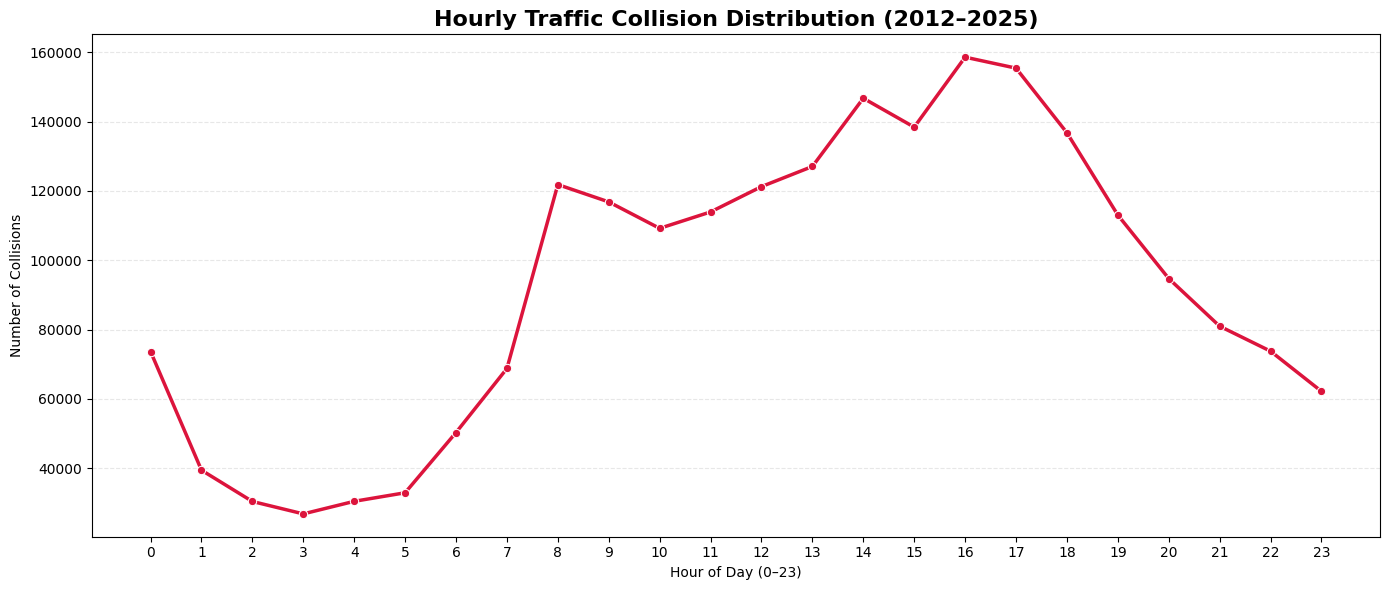

,COUNT
HOUR,
0,73685
1,39461
2,30438
3,26859
4,30482
5,32950
6,50325
7,68793
8,121833


In [15]:
# Hourly Collision Trend (Line Plot)

# A line plot provides a clearer view of how collision frequency
# fluctuates across the 24-hour day. This helps identify peak-risk
# hours during morning and evening commutes, as well as late-night
# high-severity windows often associated with impaired or fatigued
# driving.

# Calculate hourly crash counts
hourly = (
    df["HOUR"]
    .dropna()
    .value_counts()
    .sort_index()
)

# Plot Hourly Trend
plt.figure(figsize=(14, 6))
sns.lineplot(
    x=hourly.index,
    y=hourly.values,
    marker="o",
    linewidth=2.5,
    color="crimson"
)

plt.title("Hourly Traffic Collision Distribution (2012–2025)", fontsize=16, fontweight="bold")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Collisions")
plt.xticks(range(0, 24))
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# Display table of values
display(hourly.to_frame(name="COUNT"))


In [17]:
# Crash Frequency Heatmap (Day of Week × Hour of Day)

# A day–hour heatmap reveals collision patterns across the full
# weekly cycle. This is critical for identifying peak-risk periods,
# commuter-related clusters, weekend late-night spikes, and temporal
# anomalies. These insights directly support targeted enforcement
# planning and public safety initiatives.

# Extract day of week
df["DAY_OF_WEEK"] = df["CRASH_DATE"].dt.day_name()

# Create pivot table with Day (rows) × Hour (columns)
heatmap_data = (
    df.groupby(["DAY_OF_WEEK", "HOUR"])
      .size()
      .reset_index(name="COUNT")
      .pivot_table(
          index="DAY_OF_WEEK",
          columns="HOUR",
          values="COUNT",
          fill_value=0  # ensures a clean heatmap with no NaNs
      )
)

# Ensure correct weekday ordering
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
heatmap_data = heatmap_data.reindex(weekday_order)

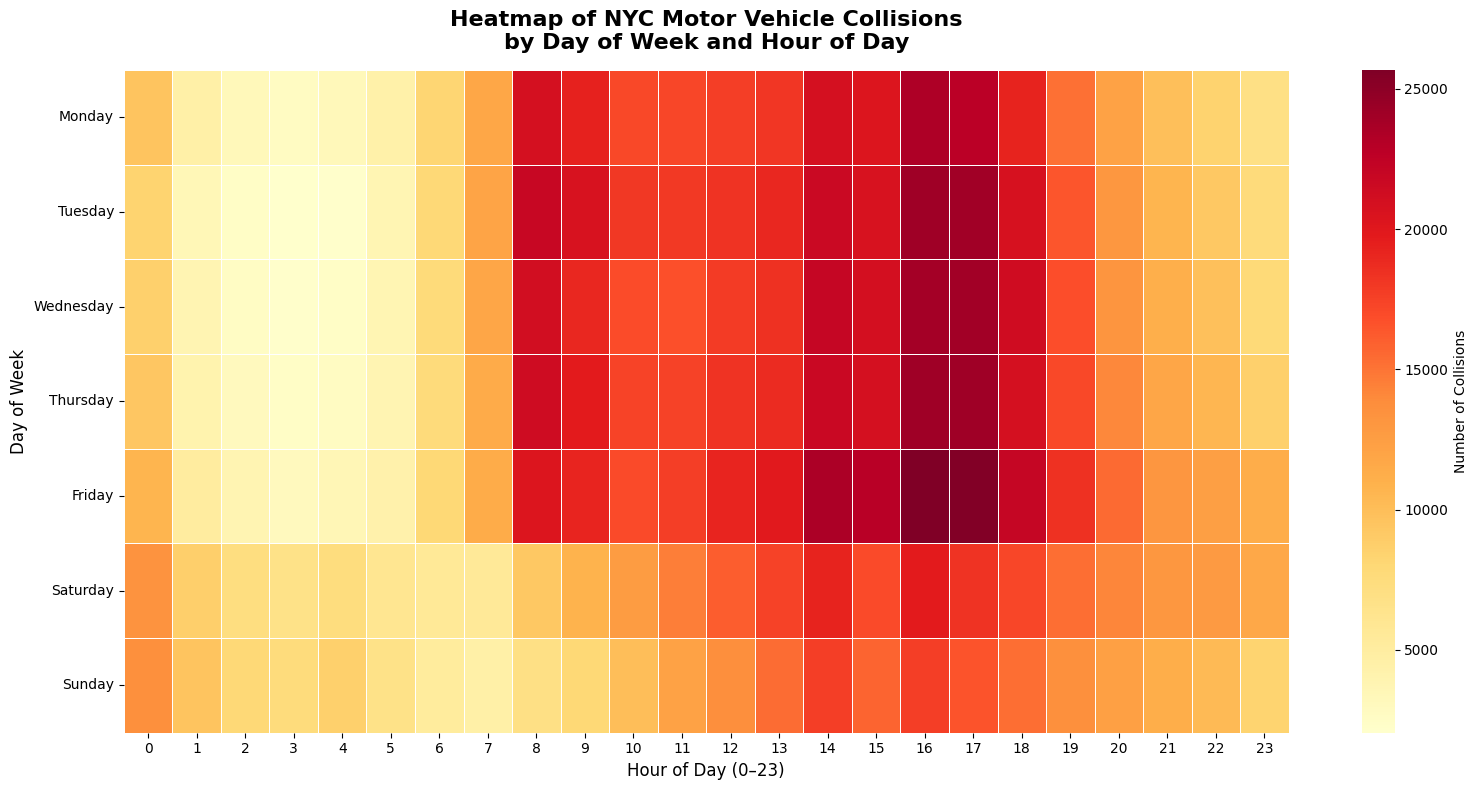

In [18]:
# Heatmap Visualization: Collision Frequency by Day & Hour

# This heatmap highlights weekly temporal patterns in collision
# frequency. By visualizing crashes across both day of week and
# hour of day, we can identify high-risk windows such as:
# - Morning and evening rush hours (weekday peaks)
# - Late-night weekend spikes (often linked to impaired driving)
# - Anomalous low-activity periods worth further examination
# These insights directly support targeted enforcement and
# operational decision-making for public safety initiatives.

plt.figure(figsize=(16, 8))
sns.heatmap(
    heatmap_data,
    cmap="YlOrRd",
    linewidths=0.4,
    linecolor="white",
    cbar_kws={"label": "Number of Collisions"}
)

plt.title(
    "Heatmap of NYC Motor Vehicle Collisions\nby Day of Week and Hour of Day",
    fontsize=16,
    fontweight="bold",
    pad=15
)

plt.xlabel("Hour of Day (0–23)", fontsize=12)
plt.ylabel("Day of Week", fontsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


Severity data (Day × Hour):


HOUR,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
DAY_OF_WEEK,,,,,,,,,,,,,,,,,,,,,,,,
Monday,3800.0,1913.0,1326.0,1067.0,1440.0,1626.0,2679.0,3927.0,5941.0,4886.0,4105.0,4353.0,4798.0,5242.0,5957.0,6626.0,7325.0,7394.0,6645.0,5456.0,4829.0,4334.0,3534.0,3083.0
Tuesday,3151.0,1328.0,936.0,785.0,826.0,1362.0,2530.0,4000.0,6435.0,5295.0,4561.0,4673.0,5003.0,5200.0,6386.0,6788.0,7396.0,7687.0,7005.0,6084.0,5202.0,4425.0,4063.0,3260.0
Wednesday,3283.0,1520.0,1061.0,847.0,1037.0,1432.0,2673.0,4118.0,6181.0,4948.0,4115.0,4516.0,4868.0,5242.0,6281.0,6889.0,7157.0,7763.0,7131.0,5932.0,5004.0,4713.0,3991.0,3256.0
Thursday,3604.0,1535.0,1111.0,920.0,1000.0,1378.0,2559.0,3984.0,6162.0,4981.0,4297.0,4511.0,5017.0,5278.0,6391.0,6660.0,7186.0,7644.0,6883.0,6111.0,5443.0,4711.0,4166.0,3555.0
Friday,3949.0,1875.0,1288.0,1148.0,1366.0,1541.0,2695.0,3865.0,5892.0,4847.0,4225.0,4715.0,5175.0,5690.0,7108.0,7362.0,7768.0,7915.0,7404.0,6522.0,5820.0,5092.0,5130.0,4657.0
Saturday,5080.0,3421.0,3076.0,2800.0,3085.0,2267.0,2088.0,1897.0,2625.0,3112.0,3577.0,4260.0,4893.0,5443.0,6105.0,5933.0,6237.0,6169.0,6337.0,5890.0,5731.0,5494.0,5345.0,5055.0
Sunday,5543.0,3872.0,3408.0,3386.0,3995.0,2689.0,1913.0,1688.0,2008.0,2293.0,2947.0,3829.0,4176.0,4875.0,5790.0,5732.0,5870.0,5957.0,5947.0,5484.0,5141.0,4859.0,4522.0,3653.0


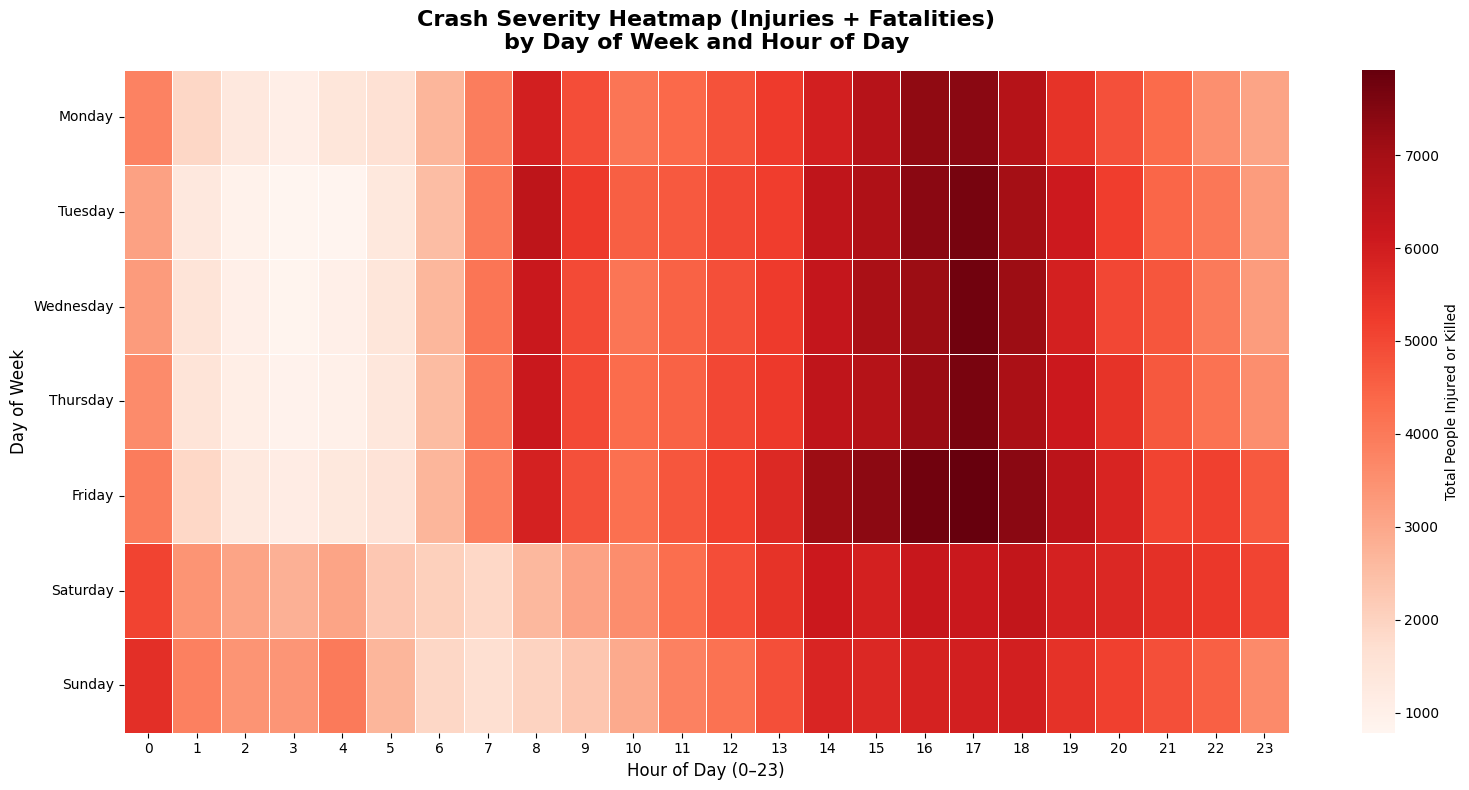

In [19]:
# Crash Severity Analysis (Injuries + Fatalities)

# In addition to collision frequency, understanding the *severity*
# of crashes (total number of people injured or killed) helps identify
# high-impact risk windows that may require targeted enforcement,
# policy interventions, or infrastructure improvements.
#
# This heatmap reveals when the most harmful collisions occur across
# the weekly cycle, highlighting periods associated with severe
# outcomes such as late-night impaired driving or high-speed crashes.

# Create a Severity Metric
# Severity = number of persons injured + number of persons killed
df["SEVERITY"] = (
    df["NUMBER_OF_PERSONS_INJURED"].fillna(0)
    + df["NUMBER_OF_PERSONS_KILLED"].fillna(0)
)

# Aggregate Severity by Day and Hour
severity_data = (
    df.groupby(["DAY_OF_WEEK", "HOUR"])["SEVERITY"]
      .sum()
      .reset_index()
      .pivot_table(
          index="DAY_OF_WEEK",
          columns="HOUR",
          values="SEVERITY",
          fill_value=0
      )
)

# Correct weekday ordering
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
severity_data = severity_data.reindex(weekday_order)

print("Severity data (Day × Hour):")
display(severity_data)

# Heatmap Visualization: Crash Severity by Day & Hour

plt.figure(figsize=(16, 8))
sns.heatmap(
    severity_data,
    cmap="Reds",
    linewidths=0.4,
    linecolor="white",
    cbar_kws={"label": "Total People Injured or Killed"}
)

plt.title(
    "Crash Severity Heatmap (Injuries + Fatalities)\nby Day of Week and Hour of Day",
    fontsize=16,
    fontweight="bold",
    pad=15
)

plt.xlabel("Hour of Day (0–23)", fontsize=12)
plt.ylabel("Day of Week", fontsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


# Geo Spatial Analysis

Borough Count Table Columns: ['BOROUGH', 'COUNT']


,BOROUGH,COUNT
0,Unknown,680912
1,Brooklyn,494538
2,Queens,413407
3,Manhattan,341826
4,Bronx,228452


/tmp/ipython-input-2053083229.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


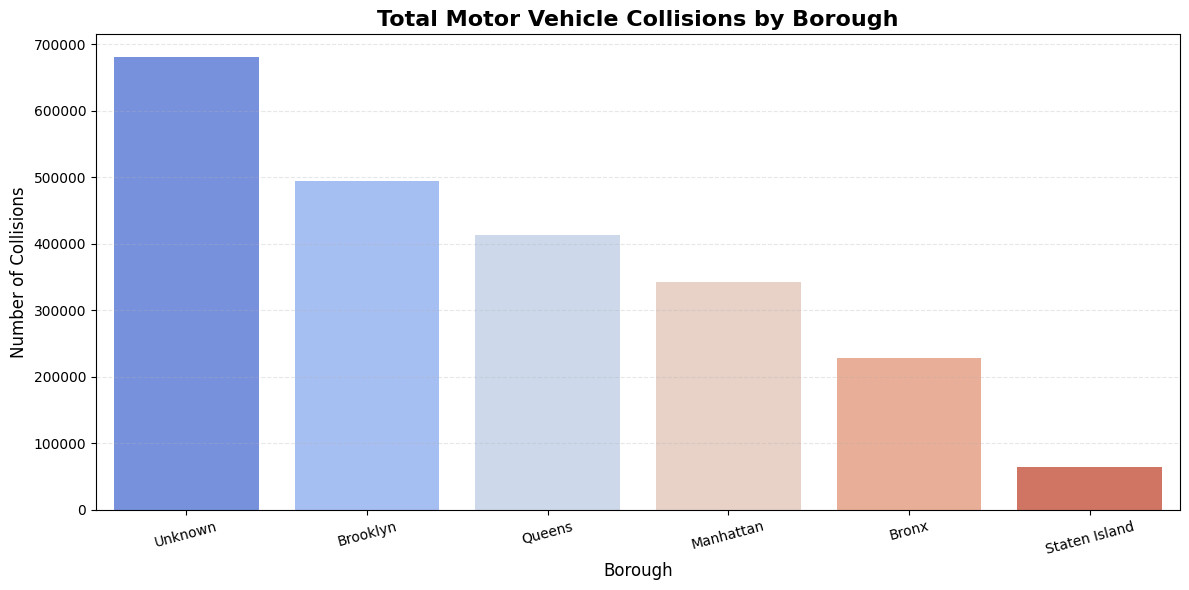

In [25]:
# Collision Distribution by Borough

# Spatial analysis of collision frequency across NYC boroughs helps
# identify geographic disparities in traffic risk. These differences
# may reflect variations in population density, roadway structure,
# traffic volume, enforcement presence, or infrastructure conditions.
# Borough-level analysis provides essential context for targeting
# safety initiatives and resource allocation.

# Clean and Standardize BOROUGH Column
df["BOROUGH"] = (
    df["BOROUGH"]
      .fillna("Unknown")
      .str.strip()
      .str.title()
)

# Create Borough Count Table
borough_counts = (
    df["BOROUGH"]
      .value_counts()
      .reset_index()
)

# Assign clear column names
borough_counts.columns = ["BOROUGH", "COUNT"]

print("Borough Count Table Columns:", borough_counts.columns.tolist())
display(borough_counts.head())

# Plot Borough Collision Counts
plt.figure(figsize=(12, 6))
sns.barplot(
    data=borough_counts,
    x="BOROUGH",
    y="COUNT",
    palette="coolwarm"
)

plt.title("Total Motor Vehicle Collisions by Borough", fontsize=16, fontweight="bold")
plt.xlabel("Borough", fontsize=12)
plt.ylabel("Number of Collisions", fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

,TOTAL_SEVERITY
BOROUGH,
Unknown,249829.0
Brooklyn,174326.0
Queens,132373.0
Bronx,79758.0
Manhattan,78402.0
Staten Island,19570.0


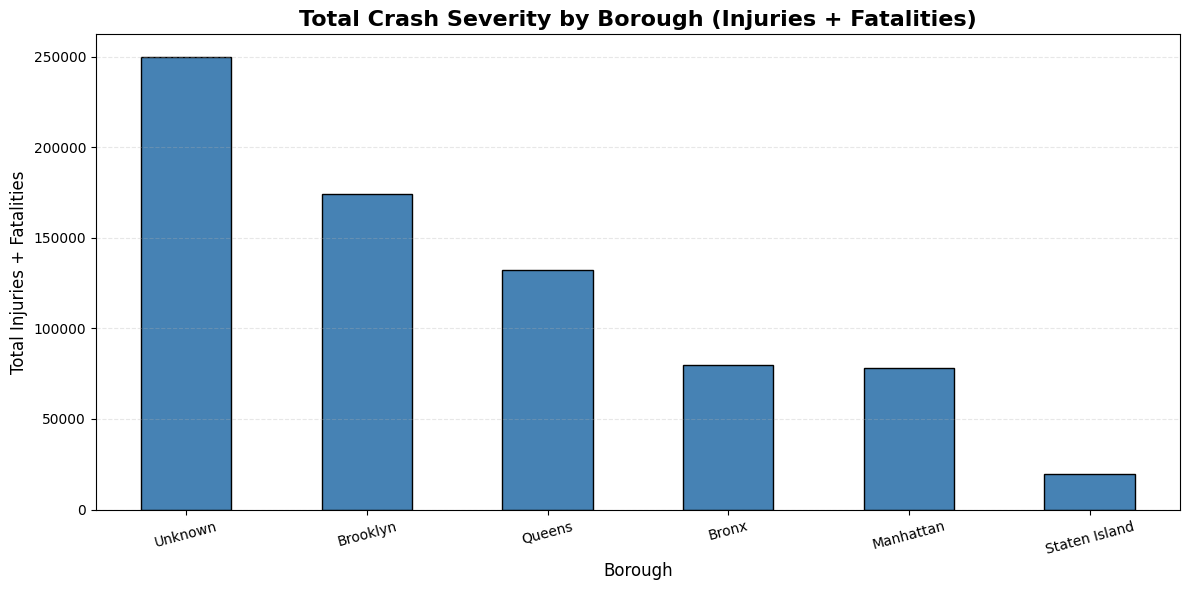

In [26]:
# Crash Severity by Borough (Injuries + Fatalities)

# In addition to collision frequency, analyzing crash *severity*—
# measured as the total number of people injured or killed—reveals
# which boroughs experience the most harmful incidents. This provides
# spatial insight into where severe crashes cluster and supports
# targeted interventions, resource planning, and policy evaluation.


# Ensure BOROUGH column is clean
df["BOROUGH"] = (
    df["BOROUGH"]
      .fillna("Unknown")
      .str.strip()
      .str.title()
)

# Aggregate total severity by borough
severity_by_borough = (
    df.groupby("BOROUGH")["SEVERITY"]
      .sum()
      .sort_values(ascending=False)
)

# Display underlying table for clarity
display(severity_by_borough.to_frame("TOTAL_SEVERITY"))

# Plot Severity by Borough
plt.figure(figsize=(12, 6))
severity_by_borough.plot(
    kind="bar",
    color="steelblue",
    edgecolor="black"
)

plt.title("Total Crash Severity by Borough (Injuries + Fatalities)", fontsize=16, fontweight="bold")
plt.xlabel("Borough", fontsize=12)
plt.ylabel("Total Injuries + Fatalities", fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


Data for Dash Board

In [27]:
# Export Files for Analysis and Visualization

# Two exports are created:
# 1. Full dataset (cleaned) — for reproducibility, auditing, and
#    advanced Python-based analysis.
# 2. Tableau-ready dataset — a lightweight curated subset used for
#    dashboarding, visualization, and exploratory BI work in Tableau.

# 1. Export Full Processed Dataset
full_export_path = "NYC_Traffic_Full.csv"
df.to_csv(full_export_path, index=False)
print(f"Full processed dataset exported to: {full_export_path}")


# 2. Create Curated Tableau Dataset
tableau_columns = [
    "CRASH_DATE", "YEAR", "MONTH", "DAY_OF_WEEK", "HOUR",
    "BOROUGH", "ZIP_CODE", "LATITUDE", "LONGITUDE",
    "NUMBER_OF_PERSONS_INJURED", "NUMBER_OF_PERSONS_KILLED",
    "NUMBER_OF_PEDESTRIANS_INJURED", "NUMBER_OF_PEDESTRIANS_KILLED",
    "NUMBER_OF_CYCLIST_INJURED", "NUMBER_OF_CYCLIST_KILLED",
    "NUMBER_OF_MOTORIST_INJURED", "NUMBER_OF_MOTORIST_KILLED",
    "CONTRIBUTING_FACTOR_VEHICLE_1", "VEHICLE_TYPE_CODE_1"
]

tableau_df = df[tableau_columns].copy()

# Add Severity Metric to Tableau Export
tableau_df["SEVERITY"] = (
    tableau_df["NUMBER_OF_PERSONS_INJURED"].fillna(0)
    + tableau_df["NUMBER_OF_PERSONS_KILLED"].fillna(0)
)

# Export Tableau Dataset
tableau_export_path = "NYC_Traffic_Clean.csv"
tableau_df.to_csv(tableau_export_path, index=False)
print(f"Tableau-ready dataset exported to: {tableau_export_path}")

Full processed dataset exported to: NYC_Traffic_Full.csv
Tableau-ready dataset exported to: NYC_Traffic_Clean.csv


In [28]:
# Download Tableau Dataset (for Local Use)

# This step allows the curated Tableau-ready dataset to be downloaded
# directly from Google Colab to your local machine. This is useful
# when preparing dashboards, submitting deliverables, or transferring
# data to other environments.

from google.colab import files

download_file = "NYC_Traffic_Clean.csv"
files.download(download_file)

print(f"Download initiated for: {download_file}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated for: NYC_Traffic_Clean.csv
